In [1]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import os
%matplotlib inline

# Defining VPD Function
def vpdfun (T_Grid, RH_Grid): 
    '''
    Uses the inputs of Temperature (Celsius) and relative humidity (%RH) and outputs the VPD (kPa).
    Inputs must be in numpy 2D array T in Celsius and RH in %RH with same dimensions.
    Author: Nathan Hein
    Date: 03/03/2019    
    '''
    esat = .611 * (np.exp((T_Grid * 17.5) / (T_Grid + 241))) # Sat. Vapor Pressure
    eact = esat * (RH_Grid / 100)                            # Actual Vapor Pressure
    vpd = esat - eact                                        # Vapr Pressure Deficit
    vpd = np.round(vpd, 2) 
    return vpd



In [6]:
# Set variables for data directory, results directory, and file name.  
#Import CSV file, trim off top row, drop unneccessary columns, rename columns.

datadirname = '/Users/nhein/Desktop/Coding/Project/Data/'
resultsdirname = '/Users/nhein/Desktop/Coding/Project/Results/'

datafile = 'CH5-36C.csv'
start_date = ['2018-12-20']
end_date = ['2018-12-28']

filename = datafile.split('.')[0]

if os.path.isdir(resultsdirname + filename) == False:
    os.makedirs(resultsdirname + filename)

date_range_df = pd.DataFrame(start_date)
date_range_df.columns = ['Start_Date']
date_range_df.insert(1, 'End_Date', end_date)
date_range_df.Start_Date = pd.to_datetime(date_range_df.Start_Date)
date_range_df.Start_Date = date_range_df.Start_Date.dt.date
date_range_df.End_Date = pd.to_datetime(date_range_df.End_Date)
date_range_df.End_Date = date_range_df.End_Date.dt.date

df = pd.read_csv(datadirname + datafile, skiprows=1)
df.drop(df.columns[[0, 4, 5, 6]], axis=1, inplace= True)
df.columns = ['Full_Date', 'Temp_C', 'RH']

# Change dates to datetime and create new columns with date data needed for calculations
df.Full_Date = pd.to_datetime(df.Full_Date)
df.insert(1,'Date', df.Full_Date.dt.date)
df.insert(2,'Time', df.Full_Date.dt.time)
df.insert(3, 'Hour', df.Full_Date.dt.hour)

# drop rows witn NaNs
df = df.dropna()

k = 0
start_date_index = []
end_date_index = []
len_date = len(df.Date)


for k in range(0, len_date):
    if df.Date[k] == date_range_df.Start_Date[0]:
        start_date_index.append(k) 
    if df.Date[k] == date_range_df.End_Date[0]:
        end_date_index.append(k)

df = df.drop(index = range(0, start_date_index[0]))
df = df.drop(index = range(end_date_index[-1] + 1, len_date))
df = df.reset_index(drop = True) 

# Defining Temp and RH variables
T_Grid = df.Temp_C
RH_Grid = df.RH

# Calling function and creating new column in dataframe with VPD.
VPD = vpdfun(T_Grid, RH_Grid)
df.insert(6,'VPD', VPD)

df.to_csv(resultsdirname + filename + '/Data')

In [7]:
# Defining function that averages the VPD values over a given hour of the day for the entire data set.
def monthlyvpd ():
    '''
    Takes the calculated VPD and averages all values that were measured during each hour of the day throughout the data period.
    Records the results in a new dataframe.
    Inputs: VPD as an integer from a dataframe created from a csv file and results are the same units as inputs (normally kPA).  
    Author: Nathan Hein
    Date: 03/11/19
    '''
    cols = ['Hour', 'VPD']
    rows = []
    xdf = pd.DataFrame(rows, columns=cols)
    vpdlist = []
    for x in range(0,24):
        vpd = df[df['Hour']==x]['VPD']
        vpdlist.append(vpd)
        avg = np.mean(vpdlist)
        xdf = xdf.append({'Hour': x, 'VPD': avg}, ignore_index=True)
        vpdlist = []
    return(xdf)

MonthlyHourlyVPD = monthlyvpd()

# Defining Function that average the temp values over a given hour of the day for the entire data set.
def monthlytemp ():
    '''
    Calculates the average temperature for each hour of the day over the entire data set.
    Inputs: Temperature as an integer in a dataframe created from a csv file.
    Outputs: Temperature as an integer and a new dataframe with average temeperature values and the hour.
    Author: Nathan Hein
    Date: 03/11/19
    '''
    cols = ['Hour', 'Temp']
    rows = []
    ydf = pd.DataFrame(rows, columns=cols)
    templist = []
    for x in range(0,24):
        temp = df[df['Hour']==x]['Temp_C']
        templist.append(temp)
        avg = np.mean(templist)
        ydf = ydf.append({'Hour': x, 'Temp': avg}, ignore_index=True)
        templist = []
    return(ydf)

MonthlyHourlyTemp = monthlytemp()

# Defining function that averages the RH values over a given hour of the day for the entire data set.
def monthlyrh ():
    '''
    Calculates the average RH value for each hour of the day over the entire data set.
    Input: RH from a dataframe created from the imported CSV file
    Output: Hourly average RH in a new dataframe and the hour.
    Author: Nathan Hein
    Date: 03/11/19
    '''
    
    cols = ['Hour', 'RH']
    rows = []
    zdf = pd.DataFrame(rows, columns=cols)
    rhlist = []
    for x in range(0,24):
        rh = df[df['Hour']==x]['RH']
        rhlist.append(rh)
        avg = np.mean(rhlist)
        zdf = zdf.append({'Hour': x, 'RH': avg}, ignore_index=True)
        rhlist = []
    return(zdf)

MonthlyHourlyRH = monthlyrh()

# Creates a list of the different Data types data frames and merges all the resuls data frames into one.
data_frames = [MonthlyHourlyTemp, MonthlyHourlyRH, MonthlyHourlyVPD]
MHA_Merged = pd.merge(pd.merge(MonthlyHourlyTemp,MonthlyHourlyRH,on='Hour'),MonthlyHourlyVPD,on='Hour')
MHA_Merged.to_csv(resultsdirname + filename + '/MHA_Merged')

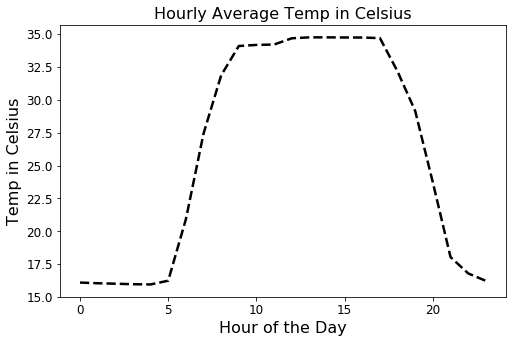

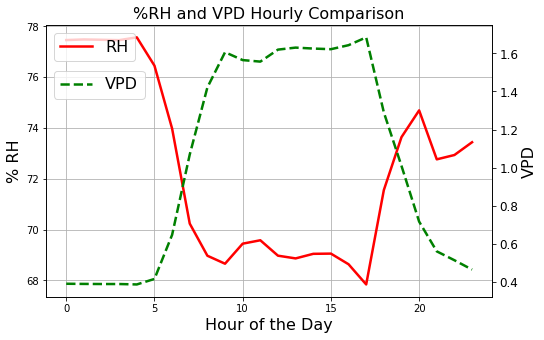

In [9]:
plt.figure(figsize=(8,5))
plt.plot(MHA_Merged.Hour, MHA_Merged.Temp, color = 'k', linewidth = 2.5, linestyle = '--')
plt.title('Hourly Average Temp in Celsius', fontsize = 16)
plt.xlabel('Hour of the Day', fontsize = 16)
plt.ylabel('Temp in Celsius', fontsize = 16)
plt.rcParams['axes.grid'] = True
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['axes.facecolor'] = 'w'

plt.savefig(resultsdirname + filename +'/HourlyAVGTemp.jpg', bbox_inches = 'tight')

plt.figure(figsize=(8,5))
plt.title('%RH and VPD Hourly Comparison', fontsize = 16)
plt.rcParams['axes.grid'] = False
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.facecolor'] = 'w'

ax1 = plt.subplot()
ax1.plot(MHA_Merged.Hour, MHA_Merged.RH, color = 'r', linewidth = 2.5)
plt.legend(loc = 'upper left', fontsize = 16)

ax2 = ax1.twinx()
ax2.plot(MHA_Merged.Hour, MHA_Merged.VPD, color = 'g', linewidth = 2.5, linestyle = '--')
plt.legend(loc = 'lower left', bbox_to_anchor = (0,.7), fontsize = 16)

ax1.set_xlabel('Hour of the Day', fontsize = 16)
ax1.set_ylabel('% RH', fontsize = 16)
ax2.set_ylabel('VPD', fontsize = 16)

plt.savefig(resultsdirname + filename + '/RHandVPDCompFig.jpg', bbox_inches = 'tight')

In [10]:
days = []
hours = [range(0,24)]
DHAdf = pd.DataFrame(hours)
DHAdf = DHAdf.drop(DHAdf.index[0])
DHAdf.insert(0,'Date','')

deltadays = date_range_df.End_Date[0] - date_range_df.Start_Date[0]

for i in range(deltadays.days + 1):
    days.append(date_range_df.Start_Date[0] + timedelta(i))

DHAdf.Date = days

HAVGTemp = []

for j in range(0,len(days)):
    for i in range(0,24):
        org = df[(df.Hour == i) & (df.Date == days[j])]
        HAVGTemp.append(org.Temp_C)
        x = np.mean(HAVGTemp)
        DHAdf[i][j] = x
        HAVGTemp = []
        
DHAdf.to_csv(resultsdirname + filename + '/DailyHourlyAverageTemp.csv',)

C:\Users\nhein\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
print(DHAdf)

         Date        0         1       2       3       4         5         6  \
0  2018-12-20  15.0940  15.08200  15.082  15.070  15.094  15.40475  20.92525   
1  2018-12-21  15.0880  15.08200  15.100  15.082  15.076  15.42275  20.93700   
2  2018-12-22  15.0880  15.05800  15.094  15.088  15.088  15.41675  20.94300   
3  2018-12-23  15.1000  15.08200  15.094  15.106  15.070  15.40475  21.01450   
4  2018-12-24  15.0940  15.07600  15.094  15.070  15.064  15.42250  20.96700   
5  2018-12-25  15.1060  15.10600  15.100  15.070  15.088  15.42275  20.97875   
6  2018-12-26  15.0580  15.05200  15.040  15.016  15.082  15.45850  21.04475   
7  2018-12-27  15.1480  15.17200  15.124  15.172  15.166  15.48800  21.08625   
8  2018-12-28  24.1935  23.78975  23.447  23.165  22.949  22.79900  20.30925   

          7         8    ...           14        15        16        17  \
0  28.29625  33.24250    ...     35.97375  35.94675  35.90650  35.96700   
1  28.31475  33.28825    ...     35.98050  35.953